<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_3_Double_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.3: Double Descent**

This notebook investigates double descent as described in section 8.4 of the book.

It uses the MNIST-1D database which can be found at https://github.com/greydanus/mnist1d

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...


In [1]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random
random.seed(0)

# Try attaching to GPU -- Use "Change Runtime Type to change to GPUT"
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [2]:
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale=2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

# Add 15% noise to training labels
for c_y in range(len(data['y'])):
    random_number = random.random()
    if random_number < 0.15 :
        random_int = int(random.random() * 10)
        data['y'][c_y] = random_int

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Length of each example: 40


In [3]:
# Initialize the parameters with He initialization
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Return an initialized model with two hidden layers and n_hidden hidden units at each
def get_model(n_hidden):

  D_i = 40    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = 10    # Output dimensions

  # Define a model with two hidden layers
  # And ReLU activations between them
  model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

  # Call the function you just defined
  model.apply(weights_init)

  # Return the model
  return model ;

In [4]:
def fit_model(model, data):

  # choose cross entropy loss function (equation 5.24)
  loss_function = torch.nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


  x_train = torch.tensor(data['x'].astype('float32')).to(DEVICE)
  y_train = torch.tensor(data['y'].transpose().astype('long')).type(torch.LongTensor).to(DEVICE) #added due to error
  x_test= torch.tensor(data['x_test'].astype('float32')).to(DEVICE)
  y_test = torch.tensor(data['y_test'].astype('long')).type(torch.LongTensor).to(DEVICE)

  model.to(DEVICE)

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  # loop over the dataset n_epoch times
  n_epoch = 1000

  for epoch in range(n_epoch):
    # loop over batches
    for i, batch in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test


The following code produces the double descent curve by training the model with different numbers of hidden units and plotting the test error.

TO DO:

*Before* you run the code, and considering that there are 4000 training examples predict:<br>

1.    At what capacity do you think the training error will become zero?
2.   At what capacity do you expect the first minima of the double descent curve to appear?
3. At what capacity do you expect the maximum of the double descent curve to appear?

In [5]:
# This code will take a while (~30 mins on GPU) to run!  Go and make a cup of coffee!

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400]) ;
errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)

# For each hidden variable size
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Get a model
    model = get_model(hidden_variables[c_hidden]) ;
    # Train the model
    errors_train, errors_test = fit_model(model, data)
    # Store the results
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test

Training model with   2 hidden variables
Epoch     0, train loss 2.302428, train error 89.57,  test loss 2.302762, test error 90.30
Epoch   100, train loss 2.302207, train error 89.57,  test loss 2.303494, test error 90.30
Epoch   200, train loss 2.302210, train error 89.57,  test loss 2.303369, test error 90.30
Epoch   300, train loss 2.302210, train error 89.57,  test loss 2.303474, test error 90.30
Epoch   400, train loss 2.302209, train error 89.57,  test loss 2.303424, test error 90.30
Epoch   500, train loss 2.302214, train error 89.57,  test loss 2.303358, test error 90.30
Epoch   600, train loss 2.302211, train error 89.57,  test loss 2.303411, test error 90.30
Epoch   700, train loss 2.302213, train error 89.57,  test loss 2.303418, test error 90.30
Epoch   800, train loss 2.302215, train error 89.57,  test loss 2.303526, test error 90.30
Epoch   900, train loss 2.302211, train error 89.57,  test loss 2.303417, test error 90.30
Training model with   4 hidden variables
Epoch   

Epoch   600, train loss 0.862905, train error 28.22,  test loss 1.828865, test error 53.37
Epoch   700, train loss 0.862951, train error 28.90,  test loss 1.963266, test error 53.32
Epoch   800, train loss 0.841004, train error 28.17,  test loss 1.982211, test error 53.02
Epoch   900, train loss 0.841001, train error 28.88,  test loss 2.047128, test error 53.37
Training model with  30 hidden variables
Epoch     0, train loss 2.186210, train error 80.80,  test loss 2.148356, test error 79.80
Epoch   100, train loss 1.181185, train error 39.15,  test loss 1.366492, test error 50.05
Epoch   200, train loss 0.971511, train error 31.90,  test loss 1.515349, test error 50.75
Epoch   300, train loss 0.882933, train error 30.00,  test loss 1.757398, test error 52.27
Epoch   400, train loss 0.809050, train error 26.57,  test loss 1.962890, test error 52.77
Epoch   500, train loss 0.780353, train error 25.88,  test loss 2.179576, test error 53.75
Epoch   600, train loss 0.750876, train error 24.

Epoch   300, train loss 0.007862, train error -0.00,  test loss 4.065742, test error 53.80
Epoch   400, train loss 0.004664, train error -0.00,  test loss 4.405617, test error 53.70
Epoch   500, train loss 0.003224, train error -0.00,  test loss 4.643003, test error 53.60
Epoch   600, train loss 0.002428, train error -0.00,  test loss 4.826610, test error 53.60
Epoch   700, train loss 0.001933, train error -0.00,  test loss 4.974301, test error 53.75
Epoch   800, train loss 0.001592, train error -0.00,  test loss 5.104980, test error 53.70
Epoch   900, train loss 0.001348, train error -0.00,  test loss 5.214190, test error 53.65
Training model with  90 hidden variables
Epoch     0, train loss 2.022272, train error 75.40,  test loss 1.933297, test error 74.93
Epoch   100, train loss 0.163522, train error 1.17,  test loss 2.283844, test error 53.90
Epoch   200, train loss 0.015888, train error -0.00,  test loss 3.535394, test error 54.47
Epoch   300, train loss 0.006834, train error -0.0

Training model with 300 hidden variables
Epoch     0, train loss 1.870595, train error 67.02,  test loss 1.787224, test error 68.32
Epoch   100, train loss 0.014792, train error -0.00,  test loss 1.956277, test error 47.67
Epoch   200, train loss 0.004857, train error -0.00,  test loss 2.192907, test error 47.12
Epoch   300, train loss 0.002748, train error -0.00,  test loss 2.321197, test error 47.12
Epoch   400, train loss 0.001870, train error -0.00,  test loss 2.409806, test error 47.27
Epoch   500, train loss 0.001398, train error -0.00,  test loss 2.476564, test error 47.32
Epoch   600, train loss 0.001107, train error -0.00,  test loss 2.531138, test error 47.40
Epoch   700, train loss 0.000911, train error -0.00,  test loss 2.576692, test error 47.42
Epoch   800, train loss 0.000771, train error -0.00,  test loss 2.616042, test error 47.45
Epoch   900, train loss 0.000666, train error -0.00,  test loss 2.650472, test error 47.50
Training model with 400 hidden variables
Epoch   

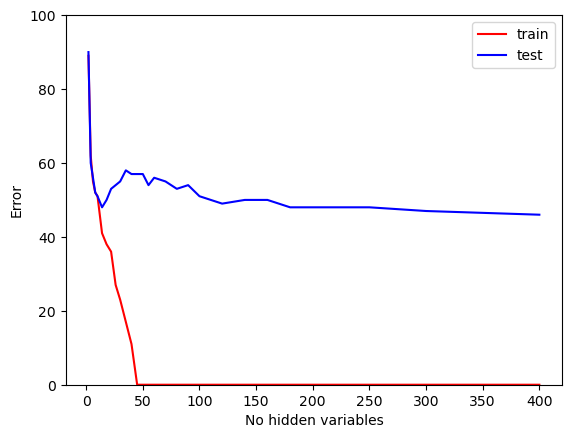

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(hidden_variables, errors_train_all,'r-',label='train')
ax.plot(hidden_variables, errors_test_all,'b-',label='test')
ax.set_ylim(0,100);
ax.set_xlabel('No hidden variables'); ax.set_ylabel('Error')
ax.legend()
plt.show()
